# Conditional MNIST Flow Matching (JAX Version)

This notebook demonstrates class-conditional flow matching on MNIST using JAX/Flax.

We implement:
* Class Conditional CFM
* Optimal Transport CFM (OT-CFM) with class conditioning
* Schrödinger Bridge CFM (SF2M) with class conditioning


In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys

# Add project root to Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
from jax import random
import optax
from diffrax import diffeqsolve, ODETerm, Tsit5, Euler, SaveAt
import torch
from torchvision import datasets, transforms
from torchvision.transforms import ToPILImage
from torchvision.utils import make_grid
from tqdm import tqdm

from jaxcfm.conditional_flow_matching import *
from jaxcfm.models.unet.unet import create_unet_model

savedir = "models/cond_mnist"
os.makedirs(savedir, exist_ok=True)


In [2]:
batch_size = 128
n_epochs = 10

# Load MNIST dataset
trainset = datasets.MNIST(
    "../data",
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]),
)

train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, drop_last=True
)


## Class Conditional CFM


In [3]:
#################################
#    Class Conditional CFM
#################################

sigma = 0.0
learning_rate = 1e-4

# Initialize model with class conditioning
key = random.PRNGKey(42)
model = create_unet_model(
    dim=(1, 28, 28), 
    num_channels=32, 
    num_res_blocks=1,
    num_classes=10,
    class_cond=True
)

# Initialize model parameters
key, subkey = random.split(key)
dummy_t = jnp.array([0.5])
dummy_x = jnp.ones((batch_size, 1, 28, 28))
dummy_y = jnp.zeros(batch_size, dtype=jnp.int32)  # Class labels
params = model.init(subkey, dummy_t, dummy_x, dummy_y)

# Initialize optimizer
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

# Initialize flow matcher
FM = ConditionalFlowMatcher(sigma=sigma)
# Users can try target FM by changing the above line by
# FM = TargetConditionalFlowMatcher(sigma=sigma)


In [4]:
# Training step function
@jax.jit
def train_step(params, opt_state, x1, y, key):
    key, subkey1, subkey2 = random.split(key, 3)
    # Sample noise
    x0 = random.normal(subkey1, x1.shape)
    
    # Sample location and conditional flow
    t, xt, ut = FM.sample_location_and_conditional_flow(subkey2, x0, x1)
    
    def loss_fn(params):
        # Model forward pass with class conditioning
        vt = model.apply(params, t, xt, y)
        loss = jnp.mean((vt - ut) ** 2)
        return loss
    
    loss, grads = jax.value_and_grad(loss_fn)(params)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    
    return params, opt_state, loss, key

# Training loop
print("Training Class Conditional CFM...")
for epoch in range(n_epochs):
    for i, data in enumerate(train_loader):
        # Convert to JAX arrays
        x1_torch = data[0]
        y_torch = data[1]
        x1 = jnp.asarray(x1_torch.numpy())
        y = jnp.asarray(y_torch.numpy(), dtype=jnp.int32)
        
        key, subkey = random.split(key)
        params, opt_state, loss, key = train_step(params, opt_state, x1, y, subkey)
        
        if (i + 1) % 100 == 0:
            print(f"epoch: {epoch}, step: {i+1}, loss: {loss:.4f}", end="\r")


Training Class Conditional CFM...


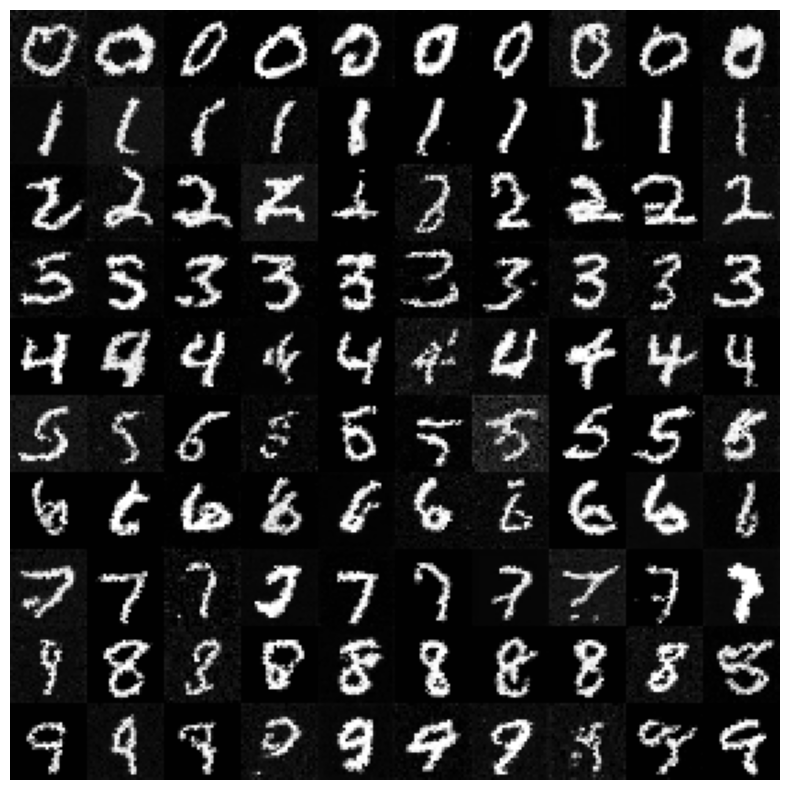

In [5]:
# Generate samples for each class
key, subkey = random.split(key)
generated_class_list = jnp.arange(10, dtype=jnp.int32).repeat(10)  # 10 samples per class
x0_init = random.normal(subkey, (100, 1, 28, 28))

# Define vector field with class conditioning
def vector_field(t, y, args):
    """Vector field: dx/dt = v_t(x, y) where y is class label"""
    class_labels = args  # Pass class labels as args
    t_batch = jnp.full((y.shape[0],), t)
    return model.apply(params, t_batch, y, class_labels)

term = ODETerm(vector_field)
solver = Tsit5()
saveat = SaveAt(ts=jnp.linspace(0.0, 1.0, 2))

# Solve ODE with class labels as args
solution = diffeqsolve(term, solver, t0=0.0, t1=1.0, dt0=0.01, y0=x0_init, 
                       saveat=saveat, args=generated_class_list)
traj = solution.ys

# Convert to numpy for visualization
traj_np = np.array(traj[-1])
traj_np = np.clip(traj_np, -1, 1)

# Create grid
traj_torch = torch.from_numpy(traj_np)
grid = make_grid(traj_torch, value_range=(-1, 1), padding=0, nrow=10)
img = ToPILImage()(grid)
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()


## Optimal Transport CFM with Class Conditioning


In [6]:
#################################
#            OT-CFM
#################################

sigma = 0.0

# Initialize model
key = random.PRNGKey(42)
model = create_unet_model(
    dim=(1, 28, 28), 
    num_channels=32, 
    num_res_blocks=1,
    num_classes=10,
    class_cond=True
)

# Initialize parameters
key, subkey = random.split(key)
dummy_t = jnp.array([0.5])
dummy_x = jnp.ones((batch_size, 1, 28, 28))
dummy_y = jnp.zeros(batch_size, dtype=jnp.int32)
params = model.init(subkey, dummy_t, dummy_x, dummy_y)

# Initialize optimizer
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

# Initialize flow matcher
FM = ExactOptimalTransportConditionalFlowMatcher(sigma=sigma)


In [7]:
# Training step for OT-CFM with class conditioning
@jax.jit
def train_step_ot(params, opt_state, x1, y, key):
    key, subkey1, subkey2 = random.split(key, 3)
    # Sample noise
    x0 = random.normal(subkey1, x1.shape)
    
    # Sample location and conditional flow with class guidance
    t, xt, ut, _, y1 = FM.guided_sample_location_and_conditional_flow(subkey2, x0, x1, y1=y)
    
    def loss_fn(params):
        # Model forward pass with matched class labels
        vt = model.apply(params, t, xt, y1)
        loss = jnp.mean((vt - ut) ** 2)
        return loss
    
    loss, grads = jax.value_and_grad(loss_fn)(params)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    
    return params, opt_state, loss, key

# Training loop
print("Training OT-CFM with class conditioning...")
for epoch in range(n_epochs):
    for i, data in enumerate(train_loader):
        # Convert to JAX arrays
        x1_torch = data[0]
        y_torch = data[1]
        x1 = jnp.asarray(x1_torch.numpy())
        y = jnp.asarray(y_torch.numpy(), dtype=jnp.int32)
        
        key, subkey = random.split(key)
        params, opt_state, loss, key = train_step_ot(params, opt_state, x1, y, subkey)
        
        if (i + 1) % 100 == 0:
            print(f"epoch: {epoch}, step: {i+1}, loss: {loss:.4f}", end="\r")


Training OT-CFM with class conditioning...


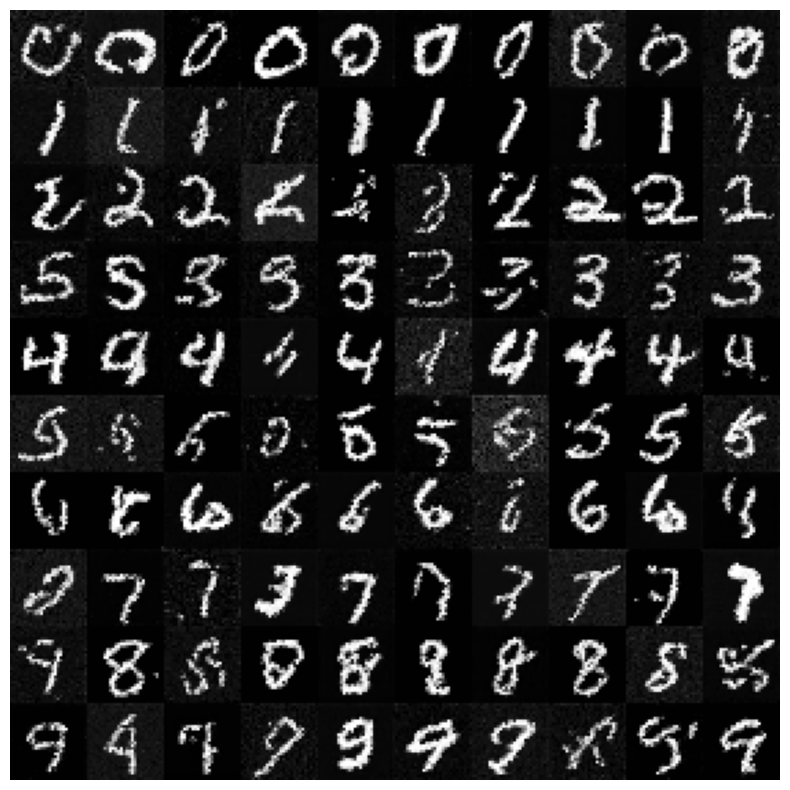

In [8]:
# Generate samples for each class
key, subkey = random.split(key)
generated_class_list = jnp.arange(10, dtype=jnp.int32).repeat(10)
x0_init = random.normal(subkey, (100, 1, 28, 28))

# Define vector field with class conditioning
def vector_field(t, y, args):
    class_labels = args
    t_batch = jnp.full((y.shape[0],), t)
    return model.apply(params, t_batch, y, class_labels)

term = ODETerm(vector_field)
solver = Tsit5()
saveat = SaveAt(ts=jnp.linspace(0.0, 1.0, 2))

# Solve ODE
solution = diffeqsolve(term, solver, t0=0.0, t1=1.0, dt0=0.01, y0=x0_init, 
                       saveat=saveat, args=generated_class_list)
traj = solution.ys

# Convert to numpy for visualization
traj_np = np.array(traj[-1])
traj_np = np.clip(traj_np, -1, 1)

# Create grid
traj_torch = torch.from_numpy(traj_np)
grid = make_grid(traj_torch, value_range=(-1, 1), padding=0, nrow=10)
img = ToPILImage()(grid)
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()


## Schrödinger Bridge CFM (SF2M) with Class Conditioning


In [ ]:
#################################
#            SF2M
#################################
batch_size = 128
n_epochs = 10
sigma = 0.1

# Initialize models (flow and score) with class conditioning
key = random.PRNGKey(42)
model = create_unet_model(
    dim=(1, 28, 28), 
    num_channels=32, 
    num_res_blocks=1,
    num_classes=10,
    class_cond=True
)
score_model = create_unet_model(
    dim=(1, 28, 28), 
    num_channels=32, 
    num_res_blocks=1,
    num_classes=10,
    class_cond=True
)

# Initialize parameters
key, subkey1, subkey2 = random.split(key, 3)
dummy_t = jnp.array([0.5])
dummy_x = jnp.ones((batch_size, 1, 28, 28))
dummy_y = jnp.zeros(batch_size, dtype=jnp.int32)
params = model.init(subkey1, dummy_t, dummy_x, dummy_y)
score_params = score_model.init(subkey2, dummy_t, dummy_x, dummy_y)

# Combine parameters
combined_params = {'model': params, 'score_model': score_params}

# Initialize optimizer
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(combined_params)

# Initialize flow matcher
FM = SchrodingerBridgeConditionalFlowMatcher(sigma=sigma)


In [10]:
# Training step for SF2M with class conditioning
@jax.jit
def train_step_sf2m(combined_params, opt_state, x1, y, key):
    key, subkey1, subkey2 = random.split(key, 3)
    # Sample noise
    x0 = random.normal(subkey1, x1.shape)
    
    # Sample location and conditional flow with class guidance
    t, xt, ut, _, y1, eps = FM.guided_sample_location_and_conditional_flow(
        subkey2, x0, x1, y1=y, return_noise=True
    )
    
    lambda_t = FM.compute_lambda(t)
    
    def loss_fn(combined_params):
        # Flow model forward pass
        vt = model.apply(combined_params['model'], t, xt, y1)
        # Score model forward pass
        st = score_model.apply(combined_params['score_model'], t, xt, y1)
        
        flow_loss = jnp.mean((vt - ut) ** 2)
        score_loss = jnp.mean((lambda_t[:, None, None, None] * st + eps) ** 2)
        loss = flow_loss + score_loss
        return loss
    
    loss, grads = jax.value_and_grad(loss_fn)(combined_params)
    updates, opt_state = optimizer.update(grads, opt_state, combined_params)
    combined_params = optax.apply_updates(combined_params, updates)
    
    return combined_params, opt_state, loss, key

# Training loop
print("Training SF2M with class conditioning...")
for epoch in range(n_epochs):
    for i, data in tqdm(enumerate(train_loader)):
        # Convert to JAX arrays
        x1_torch = data[0]
        y_torch = data[1]
        x1 = jnp.asarray(x1_torch.numpy())
        y = jnp.asarray(y_torch.numpy(), dtype=jnp.int32)
        
        key, subkey = random.split(key)
        combined_params, opt_state, loss, key = train_step_sf2m(combined_params, opt_state, x1, y, subkey)
        
        if (i + 1) % 100 == 0:
            print(f"epoch: {epoch}, step: {i+1}, loss: {loss:.4f}")


Training SF2M with class conditioning...


100it [00:39,  4.59it/s]

epoch: 0, step: 100, loss: 1.6011


200it [00:56,  4.60it/s]

epoch: 0, step: 200, loss: 1.4020


300it [01:13,  4.58it/s]

epoch: 0, step: 300, loss: 1.3205


400it [01:30,  4.59it/s]

epoch: 0, step: 400, loss: 1.3019


468it [01:42,  4.58it/s]
100it [00:16,  4.57it/s]

epoch: 1, step: 100, loss: 1.2599


200it [00:34,  4.58it/s]

epoch: 1, step: 200, loss: 1.2492


300it [00:51,  4.54it/s]

epoch: 1, step: 300, loss: 1.2256


400it [01:09,  4.57it/s]

epoch: 1, step: 400, loss: 1.2279


468it [01:20,  5.84it/s]
100it [00:17,  4.61it/s]

epoch: 2, step: 100, loss: 1.2332


200it [00:34,  4.57it/s]

epoch: 2, step: 200, loss: 1.2445


300it [00:52,  4.57it/s]

epoch: 2, step: 300, loss: 1.2360


400it [01:09,  4.55it/s]

epoch: 2, step: 400, loss: 1.2110


468it [01:20,  5.78it/s]
100it [00:16,  4.55it/s]

epoch: 3, step: 100, loss: 1.2257


200it [00:34,  4.60it/s]

epoch: 3, step: 200, loss: 1.2132


300it [00:51,  4.60it/s]

epoch: 3, step: 300, loss: 1.2706


400it [01:08,  8.53it/s]

epoch: 3, step: 400, loss: 1.2004


468it [01:20,  5.85it/s]
100it [00:17,  4.58it/s]

epoch: 4, step: 100, loss: 1.1857


200it [00:34,  4.57it/s]

epoch: 4, step: 200, loss: 1.1931


300it [00:51,  7.28it/s]

epoch: 4, step: 300, loss: 1.1638


400it [01:08,  4.56it/s]

epoch: 4, step: 400, loss: 1.2738


468it [01:20,  5.79it/s]
100it [00:16,  4.57it/s]

epoch: 5, step: 100, loss: 1.2196


200it [00:33,  5.67it/s]

epoch: 5, step: 200, loss: 1.1854


300it [00:51,  4.59it/s]

epoch: 5, step: 300, loss: 1.1785


400it [01:07,  4.58it/s]

epoch: 5, step: 400, loss: 1.2936


468it [01:19,  5.86it/s]
100it [00:16,  5.17it/s]

epoch: 6, step: 100, loss: 1.1811


200it [00:34,  4.57it/s]

epoch: 6, step: 200, loss: 1.1653


300it [00:51,  4.59it/s]

epoch: 6, step: 300, loss: 1.1881


400it [01:08,  4.59it/s]

epoch: 6, step: 400, loss: 1.1659


468it [01:19,  5.85it/s]
100it [00:17,  4.61it/s]

epoch: 7, step: 100, loss: 1.1683


200it [00:34,  4.59it/s]

epoch: 7, step: 200, loss: 1.1457


300it [00:52,  4.61it/s]

epoch: 7, step: 300, loss: 1.1593


400it [01:08,  4.59it/s]

epoch: 7, step: 400, loss: 1.1869


468it [01:20,  5.80it/s]
100it [00:16,  4.57it/s]

epoch: 8, step: 100, loss: 1.1731


200it [00:34,  4.58it/s]

epoch: 8, step: 200, loss: 1.1898


300it [00:51,  4.60it/s]

epoch: 8, step: 300, loss: 1.1580


400it [01:08,  4.58it/s]

epoch: 8, step: 400, loss: 1.1910


468it [01:19,  5.85it/s]
100it [00:17,  4.59it/s]

epoch: 9, step: 100, loss: 1.1737


200it [00:34,  4.56it/s]

epoch: 9, step: 200, loss: 1.1607


300it [00:52,  4.60it/s]

epoch: 9, step: 300, loss: 1.1436


400it [01:08,  4.57it/s]

epoch: 9, step: 400, loss: 1.1953


468it [01:20,  5.80it/s]


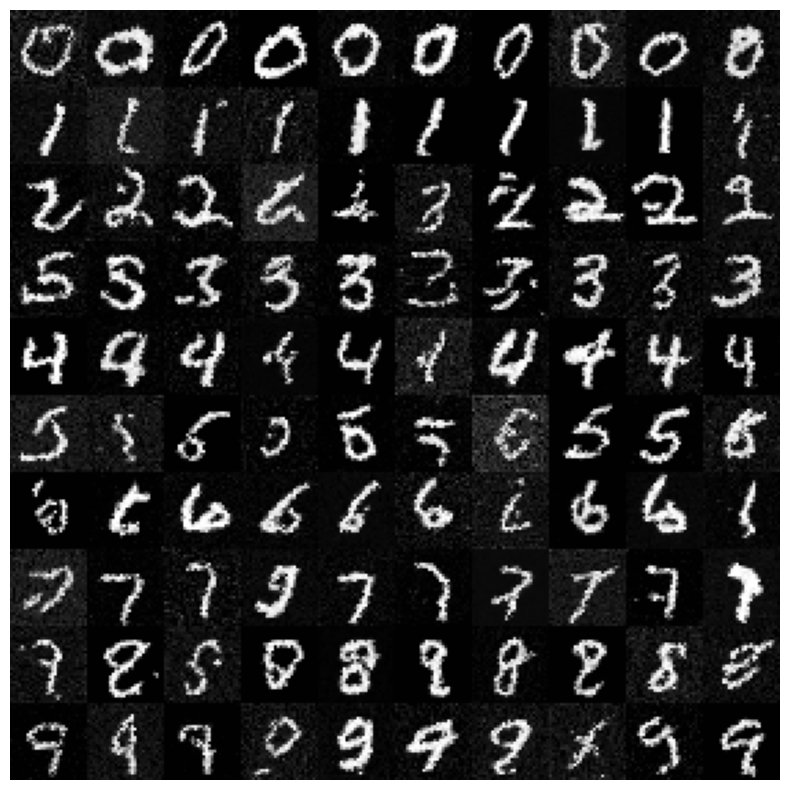

In [ ]:
# Generate samples using ODE solver (Euler method)
key, subkey = random.split(key)
generated_class_list = jnp.arange(10, dtype=jnp.int32).repeat(10)
x0_init = random.normal(subkey, (100, 1, 28, 28))

# Define vector field
def vector_field(t, y, args):
    class_labels = args
    t_batch = jnp.full((y.shape[0],), t)
    return model.apply(combined_params['model'], t_batch, y, class_labels)

term = ODETerm(vector_field)
solver = Euler()
saveat = SaveAt(ts=jnp.linspace(0.0, 1.0, 1000))

# Solve ODE
solution = diffeqsolve(term, solver, t0=0.0, t1=1.0, dt0=0.001, y0=x0_init, 
                       saveat=saveat, args=generated_class_list)
traj = solution.ys

# Convert to numpy for visualization
traj_np = np.array(traj[-1])
traj_np = np.clip(traj_np, -1, 1)

# Create grid
traj_torch = torch.from_numpy(traj_np)
grid = make_grid(traj_torch, value_range=(-1, 1), padding=0, nrow=10)
img = ToPILImage()(grid)
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()


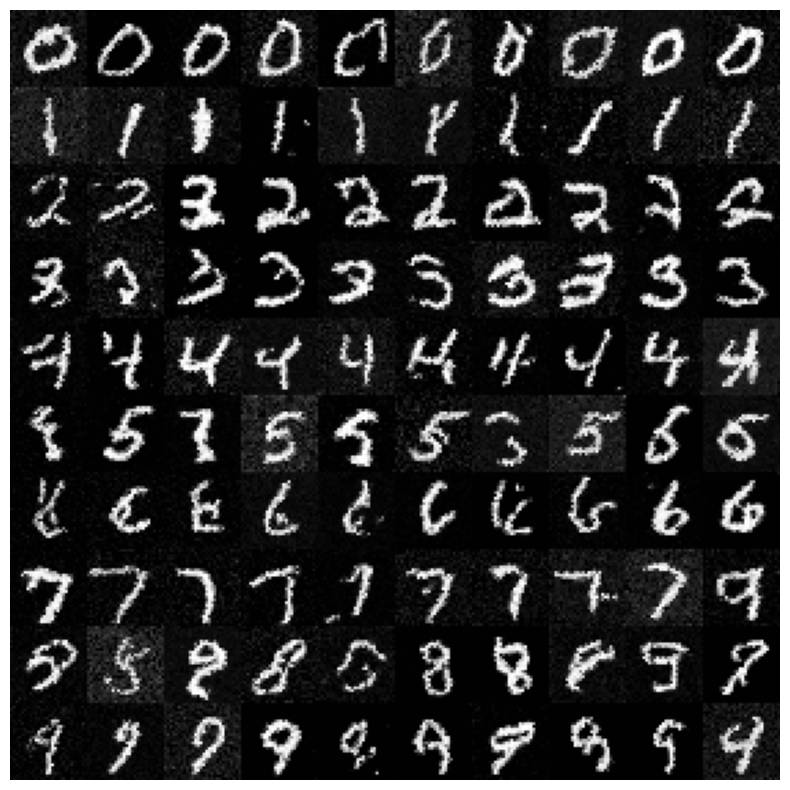

In [ ]:
# SDE generation using Euler-Maruyama method with class conditioning
def euler_maruyama_sde(f, g, x0, ts, key, args=None, dt=0.01):
    """Solve SDE: dx = f(t, x, args)dt + g(t, x)dW"""
    trajectory = [x0]
    x = x0
    key, subkey = random.split(key)
    
    for i in range(len(ts) - 1):
        t_curr = ts[i]
        
        # Drift term
        drift = f(t_curr, x, args) * dt
        
        # Diffusion term
        key, subkey = random.split(key)
        dW = random.normal(subkey, x.shape) * jnp.sqrt(dt)
        diffusion = g(t_curr, x) * dW
        
        # Euler-Maruyama step
        x = x + drift + diffusion
        trajectory.append(x)
    
    return jnp.stack(trajectory)

# Define SDE drift and diffusion with class conditioning
def drift_fn(t, y, args):
    """Drift: f(t, y, y_labels) = v_t(y, y_labels) + s_t(y, y_labels)"""
    class_labels = args
    y_reshaped = y.reshape(-1, 1, 28, 28)
    t_batch = jnp.full((y_reshaped.shape[0],), t)
    v = model.apply(combined_params['model'], t_batch, y_reshaped, class_labels)
    s = score_model.apply(combined_params['score_model'], t_batch, y_reshaped, class_labels)
    return (v + s).reshape(-1, 1 * 28 * 28)

def diffusion_fn(t, y):
    """Diffusion: g(t, y) = sigma"""
    return jnp.ones_like(y) * sigma

# Generate samples using SDE
key, subkey = random.split(key)
generated_class_list = jnp.arange(10, dtype=jnp.int32).repeat(10)
x0_sde = random.normal(subkey, (100, 1 * 28 * 28))
ts = jnp.linspace(0.0, 1.0, int(1.0 / 0.01) + 1)

sde_traj = euler_maruyama_sde(drift_fn, diffusion_fn, x0_sde, ts, key, 
                               args=generated_class_list, dt=0.01)

# Reshape and visualize
sde_traj_reshaped = sde_traj[-1].reshape(100, 1, 28, 28)
sde_traj_np = np.array(sde_traj_reshaped)
sde_traj_np = np.clip(sde_traj_np, -1, 1)

# Create grid
traj_torch = torch.from_numpy(sde_traj_np)
grid = make_grid(traj_torch, value_range=(-1, 1), padding=0, nrow=10)
img = ToPILImage()(grid)
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()
